In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import igraph as ig
import leidenalg as la

import matplotlib.pyplot as plt

In [2]:
lines = gpd.read_file("../edges_focus.gpkg").rename(columns={'target': 'src',
                                                             'focal': 'trg',
                                                             'weight': 'nij',
                                                             'distance': 'dij'})

In [8]:
import cenpy

acs = cenpy.remote.APIConnection("ACSDT5Y2018")
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 5-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census ACS 2018 WMS

In [9]:
metros = pd.read_csv("../data/metrolist_one.csv", nrows=1159, header=None)
metros = metros.set_axis(['metro_fips', 'metro_name', 'county_fips', 'county_name'], axis=1)

bay = metros[(metros.metro_name.str.contains('San Jose')) | (metros.metro_name.str.contains('San Francisco'))]
bay = bay[bay.county_name!="San Benito, CA"]

bay.head()

,metro_fips,metro_name,county_fips,county_name
963,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6001,"Alameda, CA"
964,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6013,"Contra Costa, CA"
965,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6041,"Marin, CA"
966,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6075,"San Francisco, CA"
967,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6081,"San Mateo, CA"


In [10]:
def get_nodes(fips):
    
    state = fips[:2]
    county = fips[2:]
        
    where_clause = f"STATE = {state} AND COUNTY = {county}"
    block_groups = acs.mapservice.layers[10].query(where=where_clause)
    
    block_groups = block_groups.to_crs(3857)
    
    nodes = pd.DataFrame({'X': block_groups.centroid.x,
                          'Y': block_groups.centroid.y,
                          'geometry': block_groups.geometry,
                          'cbg': block_groups.GEOID.astype('int64')}).set_index('cbg')
    
    return nodes

In [11]:
nodes = list()
shape = list()

for fips in bay.county_fips:
    
    fips = "0" + str(fips)
    
    current = get_nodes(fips)
    feature = current.geometry
    
    shape.append(feature)
    nodes.append(current.drop('geometry', axis=1))

nodes = pd.concat(nodes, ignore_index=False)
shape = gpd.GeoDataFrame(pd.concat(shape, ignore_index=False))

/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When maki

In [12]:
water = list()

for fips in bay.county_fips:
    
    fips = "0" + str(fips)
    
    year = 2018
    
    sfips = fips[:2]
    cfips = fips[2:]
    
    url = f"https://www2.census.gov/geo/tiger/TIGER{year}/AREAWATER/tl_{year}_{sfips}{cfips}_areawater.zip"
    
    water.append(gpd.read_file(url))

water = gpd.GeoDataFrame(pd.concat(water, ignore_index=True))

In [13]:
water = water.to_crs(3857)

water_dissolved = water.dissolve()
shape_dissolved = shape.dissolve()
background = shape_dissolved['geometry'].difference(water_dissolved['geometry'])

In [14]:
lines = lines.to_crs(3857)

In [125]:
%%time

from scipy import stats

modes = {}

for i in lines.period.unique():
    edges = lines[lines['period']==i][['src', 'trg', 'nij']]
    G = ig.Graph.TupleList(edges.values, 
                       weights=True, directed=True)
    
    sinks = []
    
    for j in G.vs['name']:
        mode = stats.mode(G.random_walk(j, 10000))
        mode = mode.mode
        sinks = np.concatenate([mode, sinks])
    
    mode = stats.mode(sinks)
    
    modes[i] = {'primary': G.vs['name'][int(mode.mode[0])],
                'tally': mode.count[0],
                'total': len(G.vs['name']),
                'complete': [G.vs['name'][int(sink)] for sink in sinks]}
    
    print(f"the modal stop on a random walk was {modes[i]['primary']} {modes[i]['tally']} of {modes[i]['total']} times")

the modal stop on a random walk was 060819843001 3092 of 3969 times
the modal stop on a random walk was 060855130001 994 of 3915 times
the modal stop on a random walk was 060855051002 1000 of 3915 times
the modal stop on a random walk was 060014226001 653 of 3912 times
the modal stop on a random walk was 060750206004 567 of 3936 times
the modal stop on a random walk was 060750169001 322 of 3937 times
CPU times: user 22.6 s, sys: 36.4 ms, total: 22.7 s
Wall time: 22.7 s


In [133]:
results = pd.DataFrame(modes).T.explode('complete')

0
1
2
3
4
5


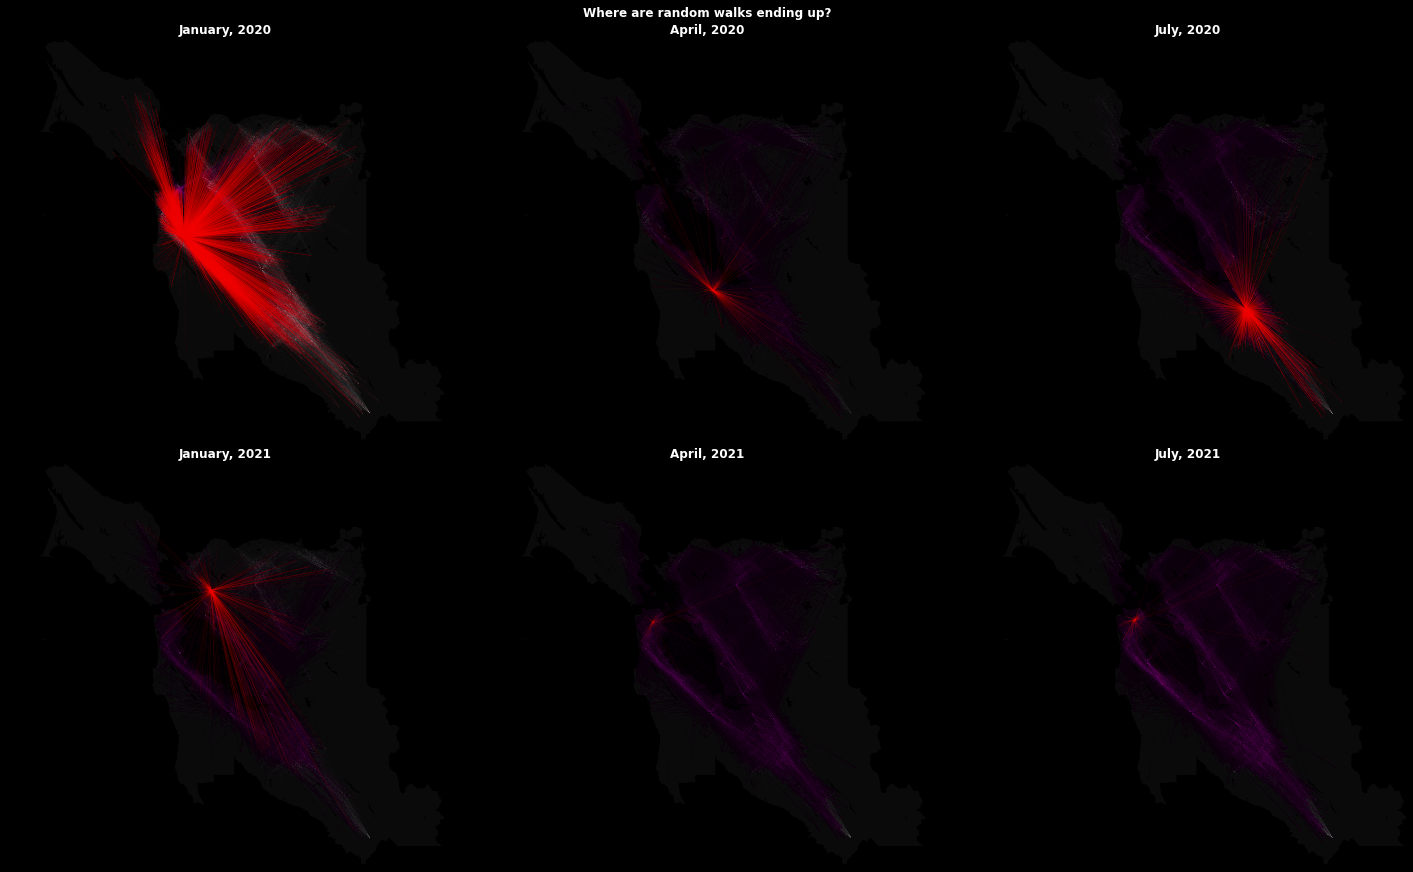

In [185]:
import matplotlib.pyplot as plt

lines['od'] = lines['src'] + " " + lines['trg']

fig, axs = plt.subplots(2, 3, figsize=(20, 12), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

for i in np.arange(0, 6):
    
    print(i)
    
    temp = results.iloc[i]
    
    unique, counts = np.unique(temp.complete, return_counts=True)
    complete = pd.DataFrame({'unique': unique,
                             'counts': counts})

    complete = complete[complete['counts']>10]['unique'].to_numpy()
    
    background.plot(color='dimgray', ax=axs[i], alpha=0.1)
    lines[lines.period==temp['index']].plot(color='white', ax=axs[i], linewidth=0.05, alpha=0.1)
    lines[lines.trg.isin(complete)].plot(color='purple', ax=axs[i], linewidth=0.05, alpha=0.1)
    lines[lines.trg==temp['primary']].plot(color='red', ax=axs[i], linewidth=0.1, alpha=0.5)

    axs[i].margins(0)
    axs[i].axis('off')
    
    axs[i].set_title(f"{temp['index']}", color='w', weight='bold')
    
fig.suptitle("Where are random walks ending up?", color='white', weight='bold')

fig.savefig('random_walkers.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')